In [4]:
import pandas as pd 
import numpy as np 
from datetime import datetime, timedelta
import requests
from shapely.geometry import Point
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import geopandas as gpd
import json

In [5]:
datetime.now()

datetime.datetime(2025, 4, 27, 12, 13, 45, 560643)

In [6]:
def fetch_earthquake_data():
    end_date = datetime.now()
    start_date = end_date - timedelta(days=45)

    url = (
        f"https://earthquake.usgs.gov/fdsnws/event/1/query?"
        f"format=geojson&starttime={start_date.strftime('%Y-%m-%d')}"
        f"&endtime={end_date.strftime('%Y-%m-%d')}&minmagnitude=4.0"
    )

    response = requests.get(url)

    return response.json()

eq_data = fetch_earthquake_data()

In [7]:
eq_data['features']


[{'type': 'Feature',
  'properties': {'mag': 4.4,
   'place': '1 km SW of Ninilchik, Alaska',
   'time': 1745697293807,
   'updated': 1745733601497,
   'tz': None,
   'url': 'https://earthquake.usgs.gov/earthquakes/eventpage/ak0255c5z643',
   'detail': 'https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=ak0255c5z643&format=geojson',
   'felt': 205,
   'cdi': 3.5,
   'mmi': 3.747,
   'alert': 'green',
   'status': 'reviewed',
   'tsunami': 1,
   'sig': 370,
   'net': 'ak',
   'code': '0255c5z643',
   'ids': ',at00svccnh,ak0255c5z643,us7000pv9w,',
   'sources': ',at,ak,us,',
   'types': ',dyfi,impact-link,losspager,origin,phase-data,shakemap,',
   'nst': None,
   'dmin': None,
   'rms': 0.68,
   'gap': None,
   'magType': 'ml',
   'type': 'earthquake',
   'title': 'M 4.4 - 1 km SW of Ninilchik, Alaska'},
  'geometry': {'type': 'Point', 'coordinates': [-151.6942, 60.0398, 55.5]},
  'id': 'ak0255c5z643'},
 {'type': 'Feature',
  'properties': {'mag': 5,
   'place': 'east of the South 

In [8]:
earthquake_list = []
for feature in eq_data["features"]:
    lon, lat, depth = feature['geometry']['coordinates']
    properties = feature["properties"]
    time = datetime.fromtimestamp(feature['properties']['time'] / 1000)
    
    earthquake_list.append({
        "longitude": lon,
        "latitude": lat,
        "depth": depth,
        "time": time,
        "sig": properties.get("sig", None),
        "tsunami": properties.get("tsunami", None),
        "gap": properties.get("gap", None),
        "dmin": properties.get("dmin", None),
        "rms": properties.get("rms", None),
        "nst": properties.get("nst", None),
        "magType": properties.get("magType", None),
        "magnitude": properties["mag"],
        "location": properties['place'],
        'geometry': Point(lon, lat)
    })

# Convert to DataFrame
df = pd.DataFrame(earthquake_list)

df.head()

,longitude,latitude,depth,time,sig,tsunami,gap,dmin,rms,nst,magType,magnitude,location,geometry
0,-151.6942,60.0398,55.500,2025-04-27 01:54:53.807,370,1,NaN,NaN,0.68,NaN,ml,4.4,"1 km SW of Ninilchik, Alaska",POINT (-151.6942 60.0398)
1,-17.9000,-57.9098,10.000,2025-04-27 00:54:10.038,385,0,82.0,10.990,0.64,55.0,mb,5.0,east of the South Sandwich Islands,POINT (-17.9 -57.9098)
2,-179.8770,-23.5935,548.596,2025-04-26 18:58:54.160,298,0,185.0,6.133,0.73,24.0,mb,4.4,south of the Fiji Islands,POINT (-179.877 -23.5935)
3,70.5952,35.9222,102.180,2025-04-26 16:36:13.928,312,0,93.0,1.844,0.49,46.0,mb,4.5,"63 km NNW of Pārūn, Afghanistan",POINT (70.5952 35.9222)
4,153.7869,-5.2776,82.422,2025-04-26 15:50:00.992,326,0,92.0,1.945,0.84,49.0,mb,4.6,"197 km ESE of Kokopo, Papua New Guinea",POINT (153.7869 -5.2776)


In [9]:
gdf = gpd.GeoDataFrame(df, geometry='geometry')

m = folium.Map(location=[0,0], zoom_start=2)


for idx, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius= row['magnitude'] * 2,
        popup=f"Magnitude: {row['magnitude']}<br>Location: {row['location']}<br>Depth: {row['depth']} km",
        color='red',
        fill=True,
        fill_color='red'
    ).add_to(m)

heat_data =  [[row['latitude'], row['longitude'], row['magnitude']] for idx, row in gdf.iterrows()]
HeatMap(heat_data).add_to(m)
m

In [29]:
m.save("earthquake_map.html")

In [12]:
df.dropna(inplace=True)

In [13]:
from sklearn import preprocessing

encoder = preprocessing.LabelEncoder()

df['magType'] = encoder.fit_transform(df['magType'])

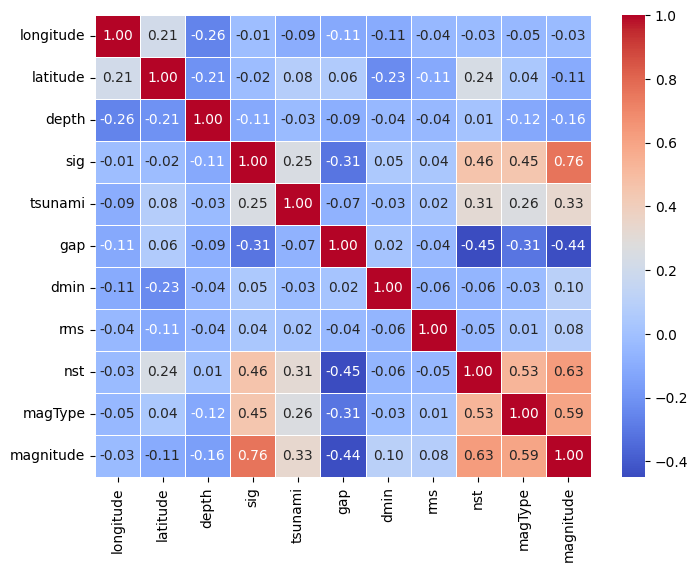

In [14]:
plt.figure(figsize=(8,6))
sns.heatmap(df.drop(columns=['location', 'time', 'geometry']).corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

In [15]:
df_cor = df.drop(columns=['location', 'time', 'geometry']).corr()
df_cor['magnitude']

longitude   -0.031228
latitude    -0.106226
depth       -0.159836
sig          0.761672
tsunami      0.333267
gap         -0.439514
dmin         0.101505
rms          0.077815
nst          0.628647
magType      0.592905
magnitude    1.000000
Name: magnitude, dtype: float64

In [16]:
X = df[['longitude', 'latitude', 'depth', 'gap', 'dmin', 'rms',
       'magType', "tsunami", 'nst', 'sig']]
y = df['magnitude']

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train

,longitude,latitude,depth,gap,dmin,rms,magType,tsunami,nst,sig
259,126.1491,0.4975,38.218,37.0,1.247,0.85,0,0,56.0,432
1373,173.0381,-13.6407,633.722,51.0,5.928,0.66,0,0,82.0,340
642,135.6966,-1.8703,29.380,70.0,1.473,0.95,0,0,29.0,298
981,126.1894,3.4833,74.614,107.0,1.429,0.85,0,0,28.0,271
520,-178.6861,-20.7843,600.502,115.0,4.316,0.74,0,0,87.0,298
...,...,...,...,...,...,...,...,...,...,...
1104,130.8751,-6.3688,94.557,52.0,2.073,0.84,0,0,50.0,340
1139,155.6813,-7.0879,83.040,44.0,4.531,0.49,0,0,158.0,385
1303,-178.0318,-18.0798,584.809,42.0,2.949,0.75,0,0,65.0,298
868,126.4501,2.9665,46.139,145.0,2.004,0.87,0,0,24.0,259


In [18]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train,y_train)


LinearRegression()

In [19]:
y_pred_lr = lr.predict(X_test)

In [30]:
comparison_lr = pd.DataFrame({
    "Actual Data": y_test,
    "Predicted Data": y_pred_lr
})
comparison_lr

,Actual Data,Predicted Data
503,4.9,4.696485
1271,4.4,4.258628
417,4.2,4.391810
1056,4.2,4.200545
1043,4.3,4.452814
...,...,...
483,4.9,4.698572
680,4.5,4.338600
1307,5.1,4.817105
655,4.4,4.457655


In [22]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(n_estimators=100, random_state=42)

reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [23]:
y_pred_reg = reg.predict(X_test)

In [24]:
comparison_rf = pd.DataFrame({
    "Actual Data": y_test,
    "Predicted Data": y_pred_reg
})
comparison_rf

,Actual Data,Predicted Data
503,4.9,4.900
1271,4.4,4.400
417,4.2,4.200
1056,4.2,4.200
1043,4.3,4.300
...,...,...
483,4.9,4.900
680,4.5,4.500
1307,5.1,5.096
655,4.4,4.400


In [25]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def metrics(y_test, y_pred):    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse) 
    r2 = r2_score(y_test, y_pred)

    return mae, mse, rmse, r2

model_predictions = {
    "Linear Regression": y_pred_lr,
    "Random Forest": y_pred_reg
}

results = []

for model_name, y_pred in model_predictions.items():
    mae, mse, rmse, r2 = metrics(y_test, y_pred)
    results.append([model_name, mae, mse, rmse, r2])

df_scores = pd.DataFrame(results, columns=["Model Name", "MAE", "MSE", "RMSE", "R2 Score"])

In [26]:
df_scores

,Model Name,MAE,MSE,RMSE,R2 Score
0,Linear Regression,0.149105,0.041222,0.203031,0.788921
1,Random Forest,0.009333,0.002569,0.050688,0.986844


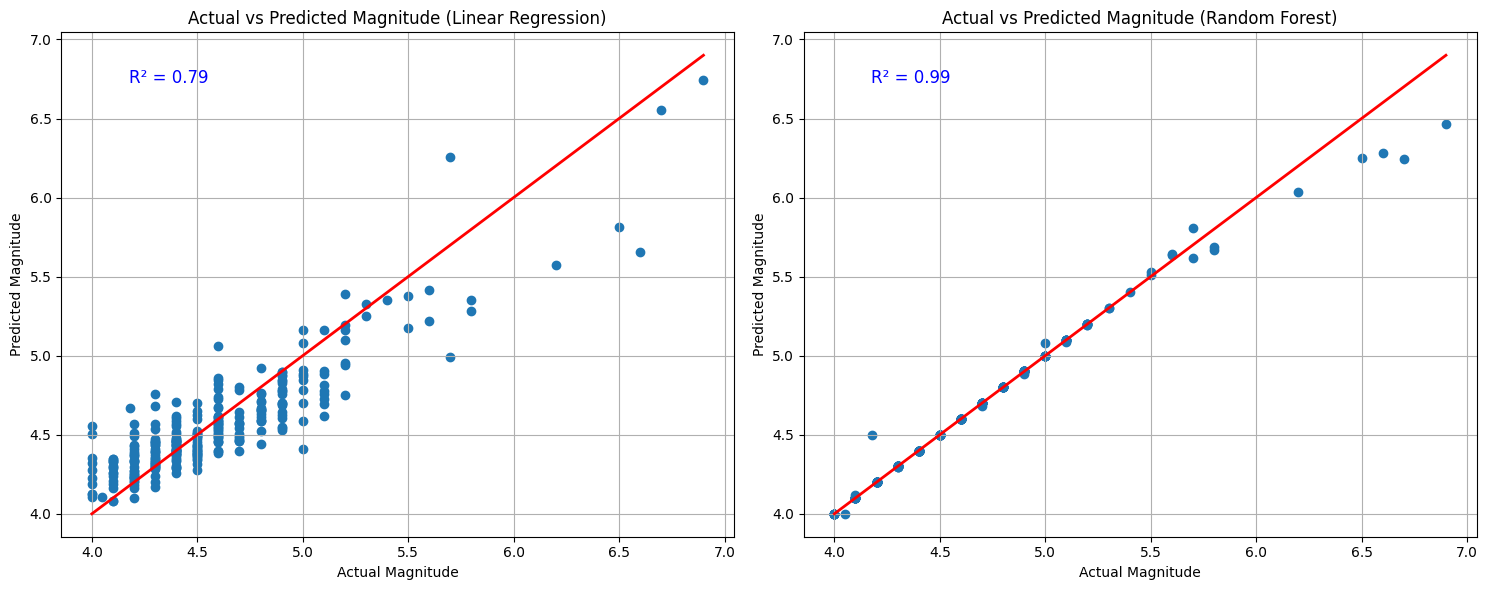

In [27]:
# Assuming y_test is the actual test data and y_pred_lr & y_pred_reg are the predictions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for Linear Regression
ax1.scatter(y_test, y_pred_lr)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)  # line of perfect prediction
ax1.set_xlabel('Actual Magnitude')
ax1.set_ylabel('Predicted Magnitude')
ax1.set_title('Actual vs Predicted Magnitude (Linear Regression)')

# Plot for Random Forest
ax2.scatter(y_test, y_pred_reg)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)  # line of perfect prediction
ax2.set_xlabel('Actual Magnitude')
ax2.set_ylabel('Predicted Magnitude')
ax2.set_title('Actual vs Predicted Magnitude (Random Forest)')

ax1.text(0.1, 0.9, f'R² = {r2_score(y_test, y_pred_lr):.2f}', transform=ax1.transAxes, fontsize=12, color='blue')
ax2.text(0.1, 0.9, f'R² = {r2_score(y_test, y_pred_reg):.2f}', transform=ax2.transAxes, fontsize=12, color='blue')

ax1.grid(True)
ax2.grid(True)


# Display both plots
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

